In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
#import seaborn as sns

import geopandas as gpd

matplotlib.rcParams['font.family'] = 'serif'


In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()

In [4]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities = cities.set_crs(sub_world.crs)
sub_cities_list = list(cities.sjoin(sub_world, how = 'right')['name_left'])[1:]
sub_cities = cities[cities['name'].isin(sub_cities_list)]

In [51]:
def get_ucdp_prio():

    with open(f'/media/simon/Seagate Expansion Drive/Bodies_dfs/PRIO/full_interpl_df_exposure.pkl', 'rb') as file:
        ucdp_prio = pickle.load(file)

    return(ucdp_prio)

ucdp_prio = get_ucdp_prio()

In [5]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_4.pkl', 'rb') as file:
    bodies_df_full = pickle.load(file)

bodies_df = bodies_df_full[(bodies_df_full['distance_days'] == 0) | (bodies_df_full['location_annot'] == 1)].copy() # only locations you are certain of

coords = gpd.GeoDataFrame(bodies_df[['longitude_full', 'latitude_full']], geometry=gpd.points_from_xy(bodies_df.longitude_full, bodies_df.latitude_full))
coords = coords.set_crs(sub_world.crs)
#coords = coords.to_crs(sub_world.crs)

bodies_df['coords'] = bodies_df['longitude_full'].astype("string") +'/'+ bodies_df['latitude_full'].astype("string")


In [7]:
list_of_features = ['person_mean', 'uniformed_mean', 'firearm_mean', 'militarized_mean', 'damaged_property_mean', 'mass_protest_mean']
bodies_df_full[list_of_features].mean(axis = 0)

person_mean              2.190914
uniformed_mean           0.330330
firearm_mean             0.067397
militarized_mean         0.129405
damaged_property_mean    0.217529
mass_protest_mean       -0.117367
dtype: float64

In [8]:
bodies_df_full[list_of_features].std(axis = 0)

person_mean              2.152298
uniformed_mean           0.744114
firearm_mean             0.264455
militarized_mean         0.379169
damaged_property_mean    0.572782
mass_protest_mean        0.266437
dtype: float64

In [9]:
for i in list_of_features:
    mask = bodies_df_full[i] >= 1
    r = mask.sum() / mask.shape[0]

    print(f'{i}: {r}')

person_mean: 0.7398809367361422
uniformed_mean: 0.12922832286382632
firearm_mean: 0.02365495308434305
militarized_mean: 0.021887402423318526
damaged_property_mean: 0.11990432885641443
mass_protest_mean: 6.570820301206403e-05


In [10]:
bodies_df_full.shape

(152188, 194)

In [11]:
bodies_df_full[list_of_features][mask].mean(axis = 0)

person_mean              2.600000
uniformed_mean           0.040000
firearm_mean             0.040000
militarized_mean        -0.196388
damaged_property_mean   -0.077985
mass_protest_mean        1.055404
dtype: float64

# In Space:

In [12]:
bodies_df.columns

Index(['person_mean', 'person_median', 'person_fasterR50', 'person_fasterR101',
       'person_fasterX101', 'person_retinaR50', 'person_retinaR101',
       'child_mean', 'child_median', 'child_retinaR50',
       ...
       'petroleum_y_observed', 'pop_gpw_sd_observed', 'pop_gpw_sum_observed',
       'prec_gpcp_observed', 'urban_ih_observed', 'cmr_mean', 'imr_mean',
       'mountains_mean', 'ttime_mean', 'coords'],
      dtype='object', length=195)

In [13]:
def get_coords_gpd( feature, bodies_df = bodies_df, sub_world = sub_world):

    if feature == None:
        unique_coords = bodies_df.groupby('coords').count()

    else:
        unique_coords = bodies_df[bodies_df[feature] >= 1].groupby('coords').count()
    
    unique_coords = unique_coords['person_mean'].reset_index() # the feature does not matter here
    unique_coords.rename(columns={'person_mean' : 'images'}, inplace= True)

    unique_coords['l_img'] = np.log(unique_coords['images']) # why?

    unique_coords['longitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,0]
    unique_coords['latitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,1]
    unique_coords.drop('coords', axis=1, inplace=True)

    coords = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.longitude_full, unique_coords.latitude_full))
    coords = coords.set_crs(sub_world.crs)

    return coords

In [14]:
coords = get_coords_gpd(None)
coords_per = get_coords_gpd('person_mean')
coords_fem = get_coords_gpd('female_mean')
coords_gar = get_coords_gpd('religiousGarmentFemale_mean')
coords_uni = get_coords_gpd('uniformed_mean')
coords_fir = get_coords_gpd('firearm_mean')

In [15]:
coords_mil = get_coords_gpd('militarized_mean')
coords_dam = get_coords_gpd('damaged_property_mean')
coords_pro = get_coords_gpd('mass_protest_mean')

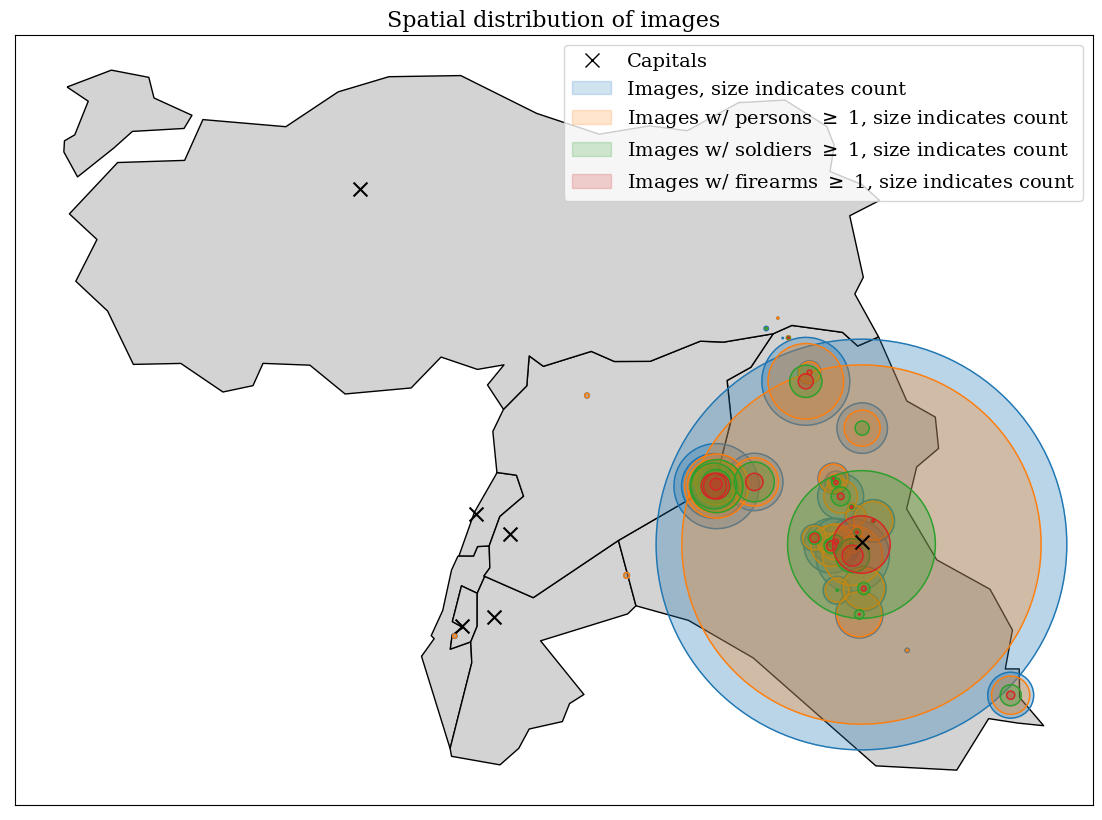

In [16]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], fc = 'none')
coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], alpha = 0.3)

coords_uni.plot(ax=ax, color='C2', marker='o', markersize = coords_uni['images'], fc = 'none')
coords_uni.plot(ax=ax, color='C2', marker='o', markersize = coords_uni['images'], alpha = 0.3)

coords_fir.plot(ax=ax, color='C3', marker='o', markersize = coords_fir['images'], fc = 'none')
coords_fir.plot(ax=ax, color='C3', marker='o', markersize = coords_fir['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_per = mpatches.Patch(color='C1', label='Images w/ persons $\geq$ 1, size indicates count', alpha = 0.2)
leg_uni = mpatches.Patch(color='C2', label='Images w/ soldiers $\geq$ 1, size indicates count', alpha = 0.2)
leg_fir = mpatches.Patch(color='C3', label='Images w/ firearms $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_images, leg_per, leg_uni, leg_fir], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map1.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

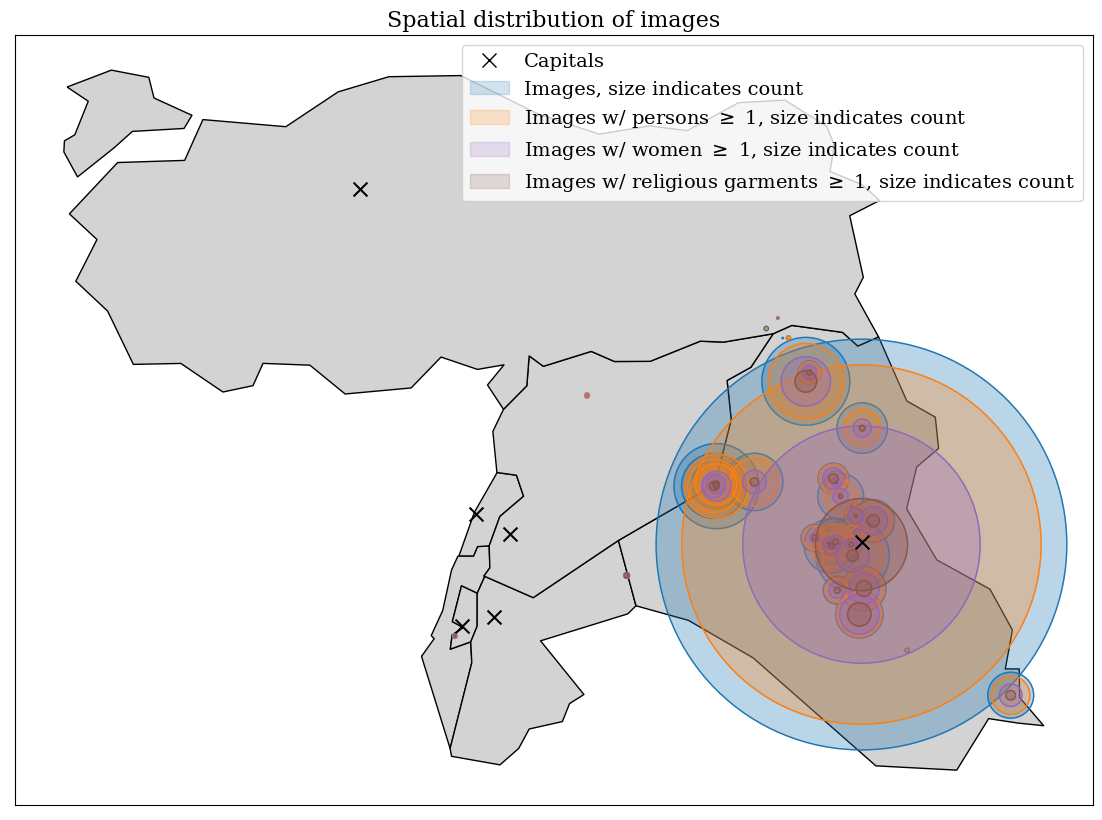

In [17]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], fc = 'none')
coords_per.plot(ax=ax, color='C1', marker='o', markersize = coords_per['images'], alpha = 0.3)

coords_fem.plot(ax=ax, color='C4', marker='o', markersize = coords_fem['images'], fc = 'none')
coords_fem.plot(ax=ax, color='C4', marker='o', markersize = coords_fem['images'], alpha = 0.3)

coords_gar.plot(ax=ax, color='C5', marker='o', markersize = coords_gar['images'], fc = 'none')
coords_gar.plot(ax=ax, color='C5', marker='o', markersize = coords_gar['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_per = mpatches.Patch(color='C1', label='Images w/ persons $\geq$ 1, size indicates count', alpha = 0.2)
leg_fam = mpatches.Patch(color='C4', label='Images w/ women $\geq$ 1, size indicates count', alpha = 0.2)
leg_gar = mpatches.Patch(color='C5', label='Images w/ religious garments $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_images, leg_per, leg_fam, leg_gar], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map2.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [18]:
count_uni = bodies_df[bodies_df['uniformed_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_uni.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_uni, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
1,Kerbala,3,406,0.007389
5,Baqouba,8,938,0.008529
3,Al Taqaddum,5,308,0.016234
4,Abu Ghraib,6,251,0.023904
7,Al-Awja,14,494,0.028340
10,Najaf,47,1160,0.040517
11,Hilla,77,1028,0.074903
15,Habbaniyah,117,1558,0.075096
14,Kirkuk,104,1325,0.078491
13,Falluja,100,1149,0.087032


In [102]:
# OLD - only annotated locations
# THIS MIGHT CHANGE WHEN YOU INFERE CITY!!!!

count_uni = bodies_df[bodies_df['uniformed_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_uni.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_uni, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
6,Al Taqaddum,5,308,0.016234
4,Samarra,3,115,0.026087
0,Abu Ghraib,1,25,0.040000
3,Kirkuk,2,50,0.040000
9,Habbaniyah,15,326,0.046012
1,Hilla,1,12,0.083333
10,Fallujah,18,132,0.136364
20,nan,14608,99177,0.147292
14,Ad Dawr,41,250,0.164000
19,Baghdad,2059,12329,0.167005


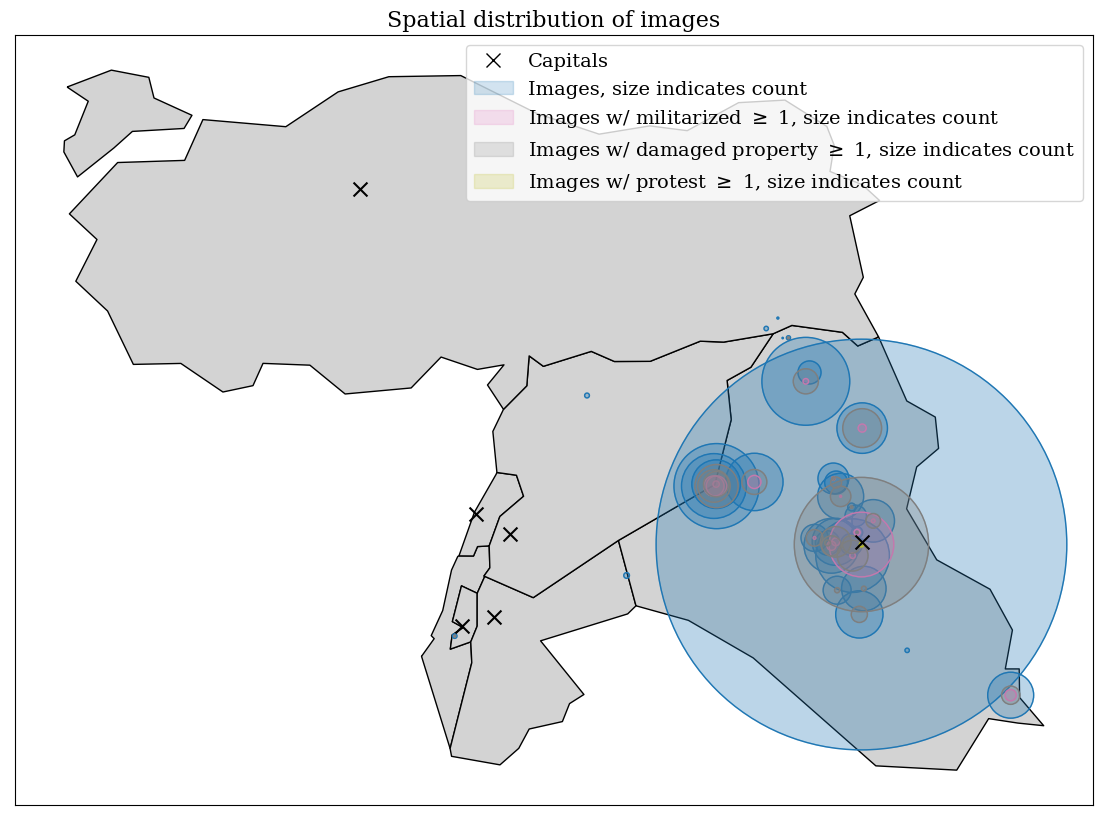

In [20]:
ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')

coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_mil.plot(ax=ax, color='C6', marker='o', markersize = coords_mil['images'], fc = 'none')
coords_mil.plot(ax=ax, color='C6', marker='o', markersize = coords_mil['images'], alpha = 0.3)

coords_dam.plot(ax=ax, color='C7', marker='o', markersize = coords_dam['images'], fc = 'none')
coords_dam.plot(ax=ax, color='C7', marker='o', markersize = coords_dam['images'], alpha = 0.3)

coords_pro.plot(ax=ax, color='C8', marker='o', markersize = coords_pro['images'], fc = 'none')
coords_pro.plot(ax=ax, color='C8', marker='o', markersize = coords_pro['images'], alpha = 0.3)

sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

plt.title('Spatial distribution of images', fontsize = 16)

plt.xticks([])
plt.yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_mil = mpatches.Patch(color='C6', label='Images w/ militarized $\geq$ 1, size indicates count', alpha = 0.2)
leg_dam = mpatches.Patch(color='C7', label='Images w/ damaged property $\geq$ 1, size indicates count', alpha = 0.2)
leg_pro = mpatches.Patch(color='C8', label='Images w/ protest $\geq$ 1, size indicates count', alpha = 0.2)


ax.legend(handles=[leg_cap, leg_images, leg_mil, leg_dam, leg_pro], fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map3.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

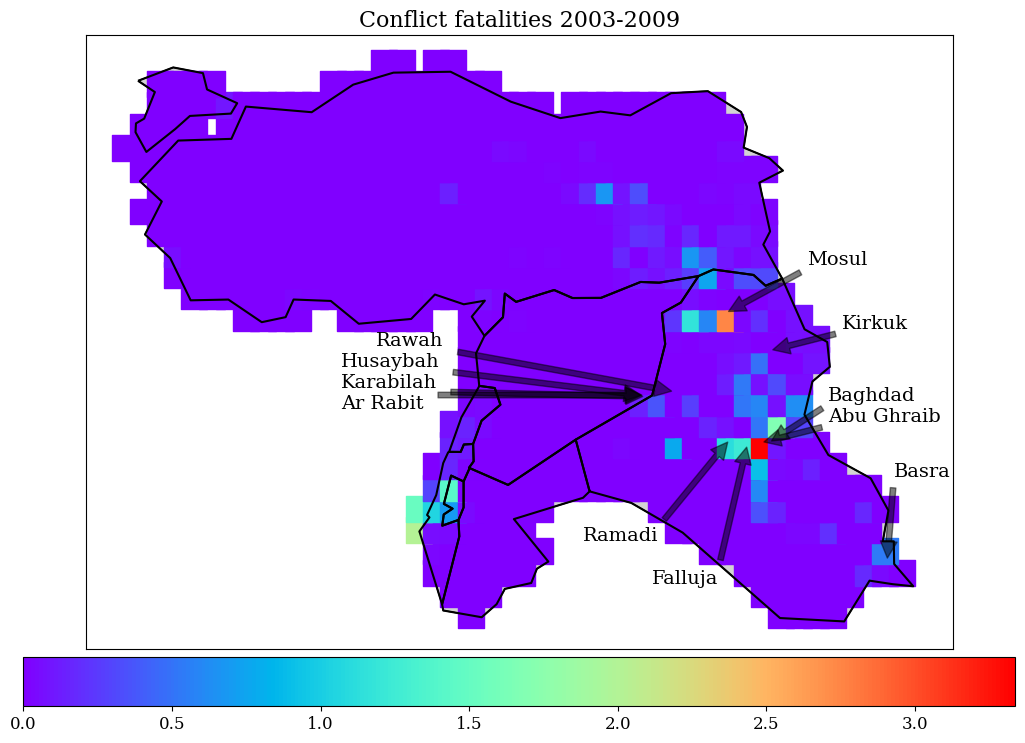

In [327]:
def city_coord(city):
    x = bodies_df.loc[bodies_df['city'] == city, 'longitude_full'].unique().item()
    y = bodies_df.loc[bodies_df['city'] == city, 'latitude_full'].unique().item()

    return(x,y)

# ---------------------
coords_dam_ratio = pd.merge(coords_dam,coords, on = ['longitude_full', 'latitude_full', 'geometry'], how = 'left')
coords_dam_ratio['ratio'] = coords_dam_ratio['images_x'] / coords_dam_ratio['images_y'] 
# ------------------

years = sorted(bodies_df['year'].unique())[1:]

sub_up = ucdp_prio.loc[ucdp_prio['year'].isin(years) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()


ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 12))
scatter = ax.scatter(sub_up['xcoord'], sub_up['ycoord'], marker = 's', s = 350, c = sub_up['log_best'], cmap = 'rainbow', alpha = 1)
cbar = plt.colorbar(scatter, location = 'bottom', shrink = 0.8, pad  = 0.01, drawedges = False) # , label= 'log(best+1)'
cbar.ax.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


sub_world.boundary.plot(ax = ax, color = 'black' , figsize=(15, 10))
#sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

#coords_dam_ratio.plot(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, fc = 'none', linewidth=2)
#coords_dam_ratio.(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, alpha = 0.2)

ax.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(45.5, 37.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46.1, 34.3), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Abu Ghraib', xy=(city_coord('Abu Ghraib')), xytext=(46.1, 33.8), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Falluja', xy=(city_coord('Falluja')), xytext=(41, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Karabilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)


plt.title('Conflict fatalities 2003-2009', fontsize = 16)

plt.xticks([])
plt.yticks([])


fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map4.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

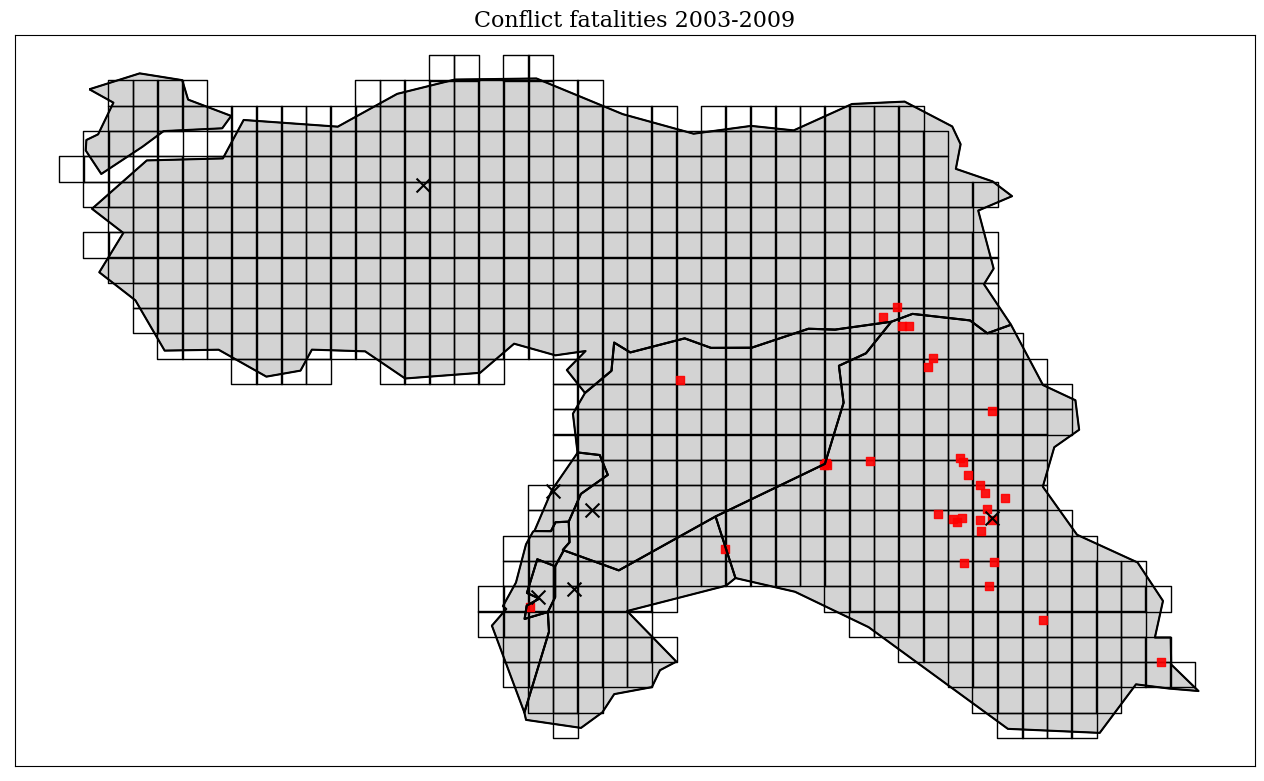

In [339]:
def city_coord(city):
    x = bodies_df.loc[bodies_df['city'] == city, 'longitude_full'].unique().item()
    y = bodies_df.loc[bodies_df['city'] == city, 'latitude_full'].unique().item()

    return(x,y)

# ---------------------
coords_dam_ratio = pd.merge(coords_dam,coords, on = ['longitude_full', 'latitude_full', 'geometry'], how = 'left')
coords_dam_ratio['ratio'] = coords_dam_ratio['images_x'] / coords_dam_ratio['images_y'] 
# ------------------

years = sorted(bodies_df['year'].unique())[1:]

sub_up = ucdp_prio.loc[ucdp_prio['year'].isin(years) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()


ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize= [16,9.5], aspect = None)

scatter = ax.scatter(sub_up['xcoord'], sub_up['ycoord'], marker = 's', s = 335, color = 'black', fc = 'none')

#coords.plot(ax=ax, color='red', marker='x', markersize = coords['images'], fc = 'none', aspect = None)
coords.plot(ax=ax, color='red', marker=',', markersize = 30, alpha = 0.9, aspect = None)


sub_world.boundary.plot(ax = ax, color = 'black' , figsize=[16,9.5], aspect = None)
sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100, aspect = None)

plt.title('Conflict fatalities 2003-2009', fontsize = 16)

plt.xticks([])
plt.yticks([])


#fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map4.png'
#plt.savefig(fig_path, bbox_inches="tight")

plt.show()

# Ratios tables

In [22]:
count_mil = bodies_df[bodies_df['militarized_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_mil.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_mil, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
0,Samarra,2,1100,0.001818
4,Mosul,16,4004,0.003996
5,nan,16,2812,0.005690
3,Baqouba,7,938,0.007463
1,Ramadi,4,380,0.010526
2,Al-Awja,6,494,0.012146
7,Ar Rabit,21,1225,0.017143
15,Baghdad,2167,87436,0.024784
9,Kirkuk,34,1325,0.025660
10,Habbaniyah,43,1558,0.027599


In [104]:
# OLD
# THIS MIGHT CHANGE WHEN YOU INFERE CITY!!!!


count_mil = bodies_df[bodies_df['all_militarized_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_mil.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_mil, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
4,Habbaniyah,2,326,0.006135
3,Fallujah,2,132,0.015152
7,Mosul,12,730,0.016438
0,Ar Rabit,1,57,0.017544
1,Kirkuk,1,50,0.020000
11,Baghdad,300,12329,0.024333
12,nan,2519,99177,0.025399
2,Ramadi,1,22,0.045455
5,Rawah,3,64,0.046875
6,Karabilah,10,186,0.053763


In [23]:
count_dam = bodies_df[bodies_df['damaged_property_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_dam.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_dam, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
5,Hilla,12,1028,0.011673
4,Al-Awja,6,494,0.012146
0,Taji,2,65,0.030769
6,Kerbala,14,406,0.034483
7,Al Taqaddum,18,308,0.058442
17,Mosul,328,4004,0.081918
3,Balad,3,32,0.093750
24,Baghdad,9358,87436,0.107027
10,Najaf,136,1160,0.117241
9,Baqouba,112,938,0.119403


In [106]:
# old
# THIS MIGHT CHANGE WHEN YOU INFERE CITY!!!!


count_dam = bodies_df[bodies_df['damaged_property_mean'] >= 1].groupby('city').count().sort_values('person_mean')[['person_mean']]
count_dam.reset_index(inplace = True)
count_all = bodies_df.groupby('city').count().sort_values('person_mean')[['person_mean']]
count_all.reset_index(inplace = True)

ratio_df = pd.merge(count_dam, count_all, on = 'city', how = 'left')
ratio_df['ratio'] = ratio_df['person_mean_x'] / ratio_df['person_mean_y']

ratio_df.sort_values('ratio')

,city,person_mean_x,person_mean_y,ratio
0,Taji,2,65,0.030769
8,Habbaniyah,14,326,0.042945
9,Al Taqaddum,18,308,0.058442
5,Rawah,5,64,0.078125
3,Balad,3,32,0.093750
16,Mosul,71,730,0.097260
19,Baghdad,1363,12329,0.110552
7,Samarra,14,115,0.121739
18,Basra,119,921,0.129207
20,nan,13012,99177,0.131200


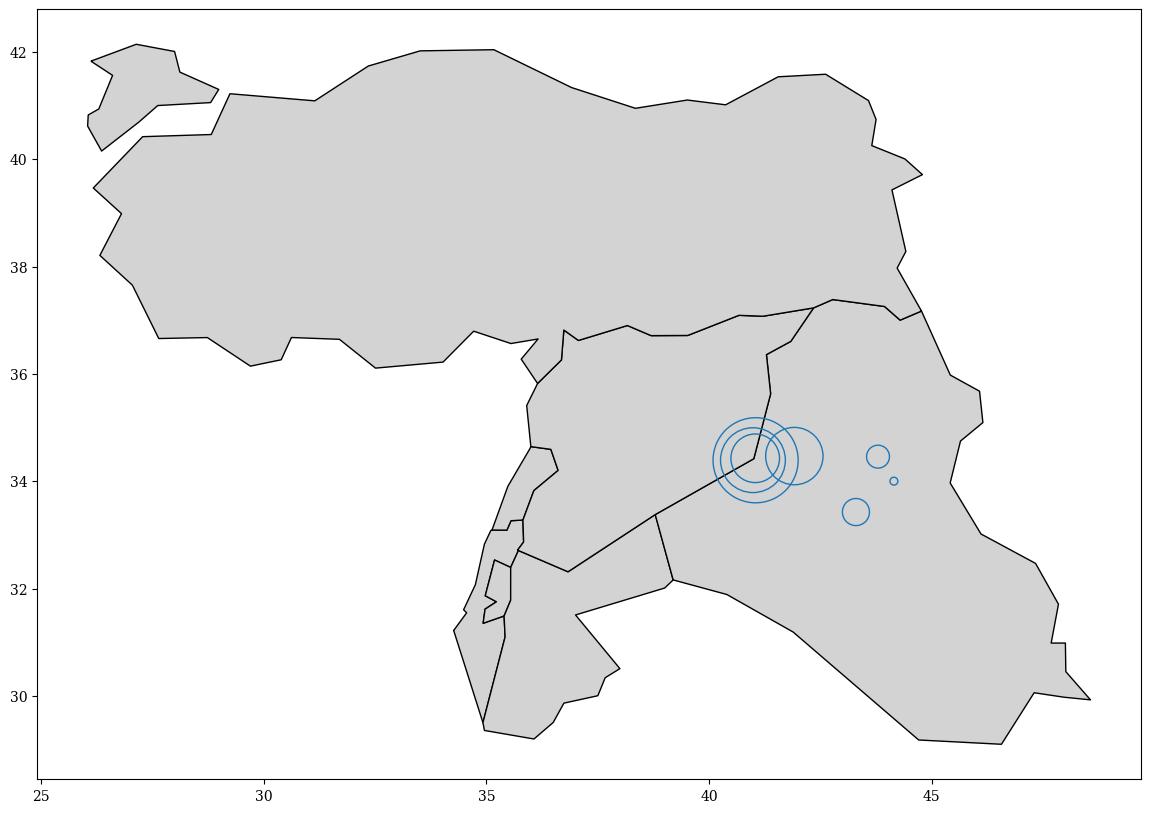

In [62]:
# Just a check
city_list = ['Husaybah', 'Karabilah', 'Ar Rabit', 'Rawah', 'Ad Dawr', 'Ramadi','Balad']
longitudes = bodies_df[bodies_df['city'].isin(city_list)]['longitude_full'].unique()
latitudes = bodies_df[bodies_df['city'].isin(city_list)]['latitude_full'].unique()

# check western atifact
sub_coords = coords[(coords['longitude_full'].isin(longitudes.astype(str))) & (coords['latitude_full'].isin(latitudes.astype(str)))]

ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 10), label = 'Capitals')
sub_coords.plot(ax=ax, color='C0', marker='o', markersize = sub_coords['images'], fc = 'none')
plt.show()

#print(bodies_df[(bodies_df['longitude_full'] == float(sub_coords['longitude_full'].iloc[0])) & (bodies_df['latitude_full'] == float(sub_coords['latitude_full'].iloc[0]))]['city'].unique())
#print(bodies_df[(bodies_df['longitude_full'] == float(sub_coords['longitude_full'].iloc[1])) & (bodies_df['latitude_full'] == float(sub_coords['latitude_full'].iloc[1]))]['city'].unique())

In [46]:
person_1_mask = bodies_df['person_mean'] > 1

In [48]:
bodies_df.loc[person_1_mask , ['person_mean', 'female_mean']]

,person_mean,female_mean
0,3.0,0.0
1,3.0,0.0
2,1.6,0.0
3,2.8,0.0
4,1.8,0.5
...,...,...
152181,4.4,0.0
152182,2.8,0.5
152184,2.0,1.0
152186,4.8,0.5


In [10]:
coords.rename(columns = {'images' : 'img_all', 'l_img' : 'l_img_all'}, inplace = True)
coords_fem.rename(columns = {'images' : 'img_fem', 'l_img' : 'l_img_fem'}, inplace = True)
coords_gar.rename(columns = {'images' : 'img_gar', 'l_img' : 'l_img_gar'}, inplace = True)
coords_uni.rename(columns = {'images' : 'img_uni', 'l_img' : 'l_img_uni'}, inplace = True)


coord_merge = coords.merge(coords_fem, how = 'outer', on = ['longitude_full', 'latitude_full', 'geometry'])
coord_merge = coord_merge.merge(coords_gar, how = 'outer', on = ['longitude_full', 'latitude_full', 'geometry'])
coord_merge = coord_merge.merge(coords_uni, how = 'outer', on = ['longitude_full', 'latitude_full', 'geometry'])

coord_merge.fillna(0, inplace = True)

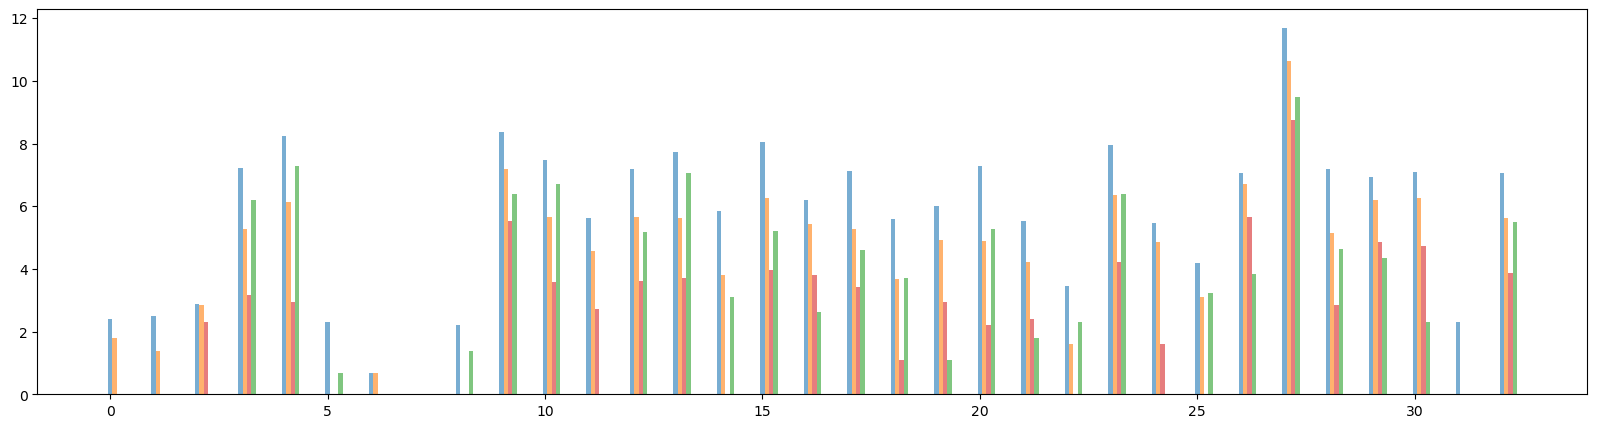

In [11]:
plt.figure(figsize=[20,5])

plt.bar(np.array(list(coord_merge.index)), coord_merge['l_img_all'], color ='C0', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.1, coord_merge['l_img_fem'], color ='C1', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.2, coord_merge['l_img_gar'], color ='C3', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.3, coord_merge['l_img_uni'], color ='C2', width = 0.1, alpha = 0.6)

plt.show()

tjek if this the places with no women are bases. ANd what about the one with same amount of women an persons?

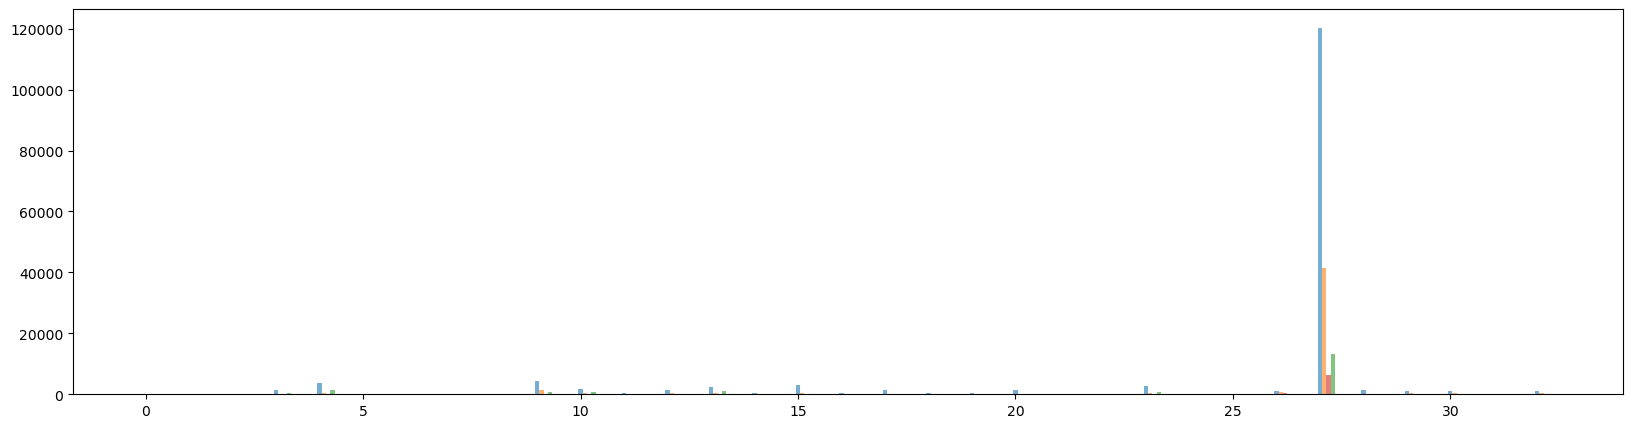

In [12]:
plt.figure(figsize=[20,5])

plt.bar(np.array(list(coord_merge.index)), coord_merge['img_all'], color ='C0', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.1, coord_merge['img_fem'], color ='C1', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.2, coord_merge['img_gar'], color ='C3', width = 0.1, alpha = 0.6)
plt.bar(np.array(list(coord_merge.index))+.3, coord_merge['img_uni'], color ='C2', width = 0.1, alpha = 0.6)

plt.show()

# In time

In [48]:
unique_months = bodies_df.groupby('month_id').count() # the feature does not matter here
unique_months = unique_months['person_mean'].reset_index()
unique_months.rename(columns={'person_mean' : 'images'}, inplace= True)

unique_months_per = bodies_df[bodies_df['person_mean'] >= 1].groupby('month_id').count() # the feature does not matter here
unique_months_per = unique_months_per['person_mean'].reset_index()
unique_months_per.rename(columns={'person_mean' : 'images'}, inplace= True)

unique_months_mal = bodies_df[bodies_df['male_mean'] >= 1].groupby('month_id').count() # the feature does not matter here
unique_months_mal = unique_months_mal['person_mean'].reset_index()
unique_months_mal.rename(columns={'person_mean' : 'images'}, inplace= True)

unique_months_fem = bodies_df[bodies_df['female_mean'] >= 1].groupby('month_id').count() # the feature does not matter here
unique_months_fem = unique_months_fem['person_mean'].reset_index()
unique_months_fem.rename(columns={'person_mean' : 'images'}, inplace= True)

unique_months_gar = bodies_df[bodies_df['religiousGarmentFemale_mean'] >= 1].groupby('month_id').count() # the feature does not matter here
unique_months_gar = unique_months_gar['person_mean'].reset_index()
unique_months_gar.rename(columns={'person_mean' : 'images'}, inplace= True)


unique_months_uni = bodies_df[bodies_df['uniformed_mean'] >= 1].groupby('month_id').count() # the feature does not matter here
unique_months_uni = unique_months_uni['person_mean'].reset_index()
unique_months_uni.rename(columns={'person_mean' : 'images'}, inplace= True)



unique_months.rename(columns = {'images' : 'img_all', 'l_img' : 'l_img_all'}, inplace = True)
unique_months_per.rename(columns = {'images' : 'img_per', 'l_img' : 'l_img_per'}, inplace = True)
unique_months_mal.rename(columns = {'images' : 'img_mal', 'l_img' : 'l_img_mal'}, inplace = True)
unique_months_fem.rename(columns = {'images' : 'img_fem', 'l_img' : 'l_img_fem'}, inplace = True)
unique_months_gar.rename(columns = {'images' : 'img_gar', 'l_img' : 'l_img_gar'}, inplace = True)
unique_months_uni.rename(columns = {'images' : 'img_uni', 'l_img' : 'l_img_uni'}, inplace = True)

months_merge = unique_months.merge(unique_months_per, how = 'outer', on = ['month_id'])
months_merge = months_merge.merge(unique_months_mal, how = 'outer', on = ['month_id'])
months_merge = months_merge.merge(unique_months_fem, how = 'outer', on = ['month_id'])
months_merge = months_merge.merge(unique_months_gar, how = 'outer', on = ['month_id'])
months_merge = months_merge.merge(unique_months_uni, how = 'outer', on = ['month_id'])

months_merge.fillna(0, inplace = True)

months_merge['per_ratio'] = months_merge['img_per']/months_merge['img_all']
months_merge['mal_ratio'] = months_merge['img_mal']/months_merge['img_all']
months_merge['fem_ratio'] = months_merge['img_fem']/months_merge['img_all']
months_merge['gar_ratio'] = months_merge['img_gar']/months_merge['img_all']
months_merge['uni_ratio'] = months_merge['img_uni']/months_merge['img_all']


months_merge['mal_per_ratio'] = (months_merge['img_mal']+1)/(months_merge['img_per']+1)
months_merge['fem_per_ratio'] = (months_merge['img_fem']+1)/(months_merge['img_per']+1)
months_merge['gar_per_ratio'] = (months_merge['img_gar']+1)/(months_merge['img_per']+1)
months_merge['uni_per_ratio'] = (months_merge['img_uni']+1)/(months_merge['img_per']+1)

months_merge['uni_mal_ratio'] = (months_merge['img_uni']+1)/(months_merge['img_mal']+1)
months_merge['uni_fem_ratio'] = (months_merge['img_uni']+1)/(months_merge['img_fem']+1)

months_merge['fem_gar_ratio'] = (months_merge['img_gar']+1)/(months_merge['img_fem']+1)


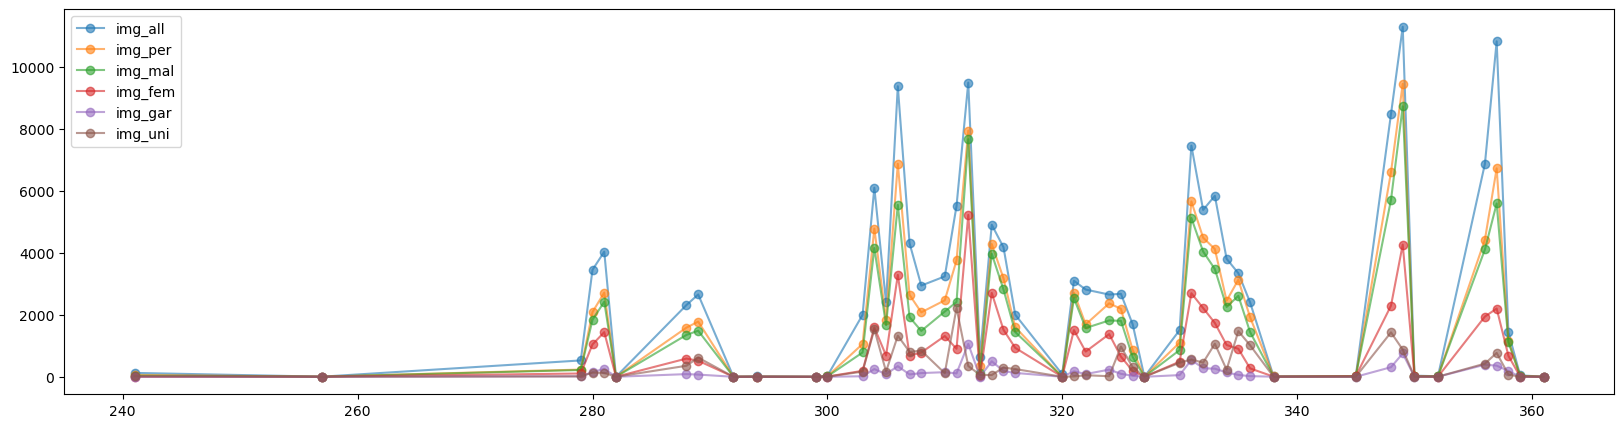

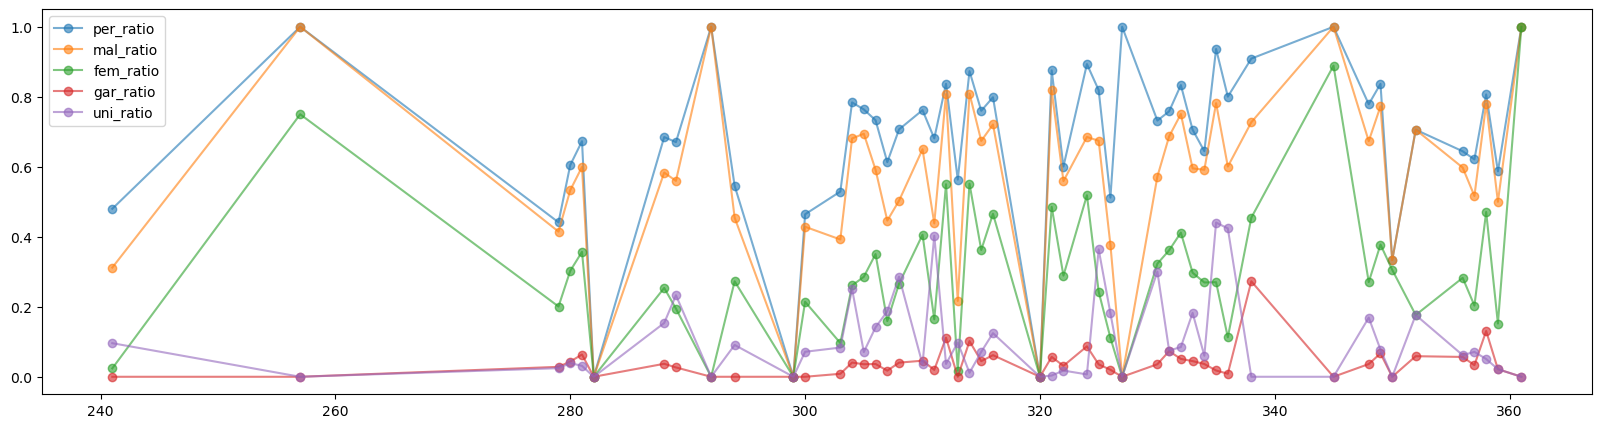

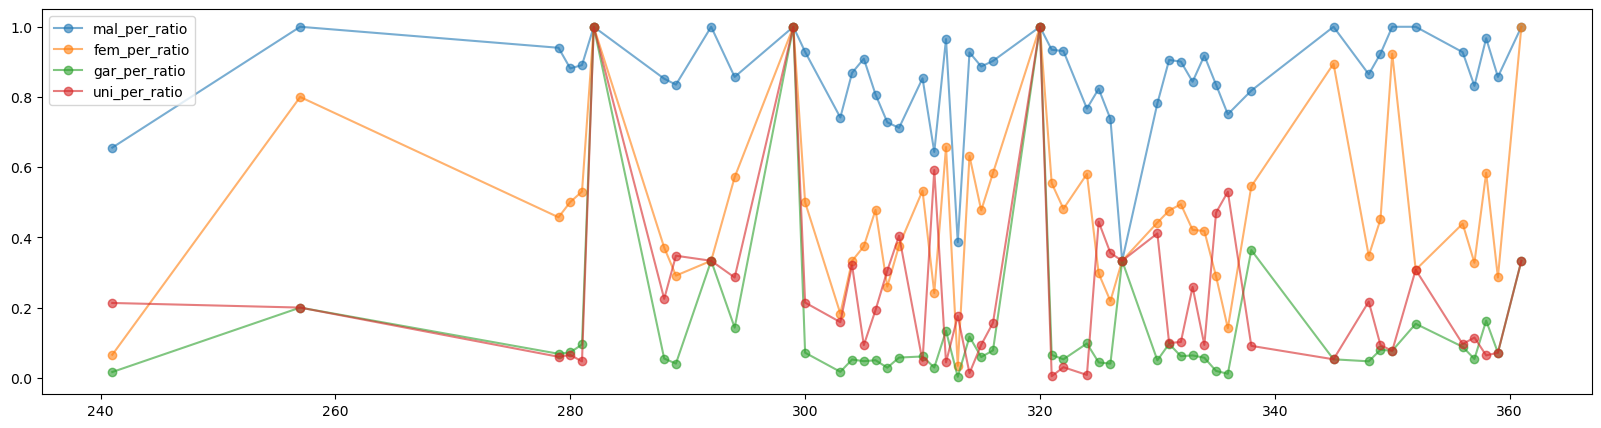

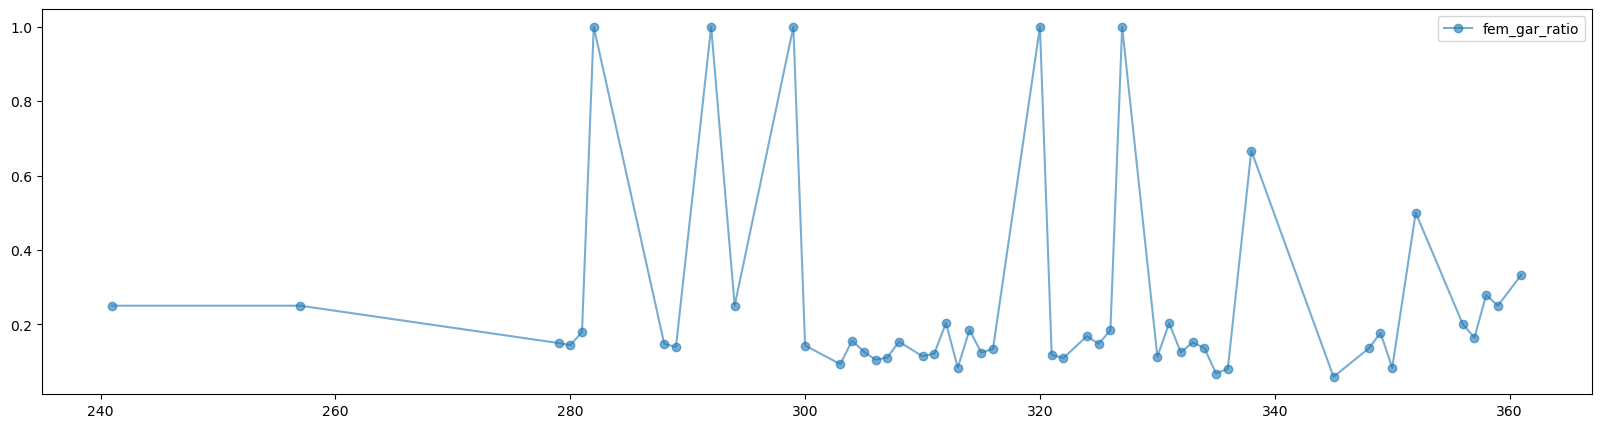

In [50]:
plt.figure(figsize=[20,5])

for i in ['img_all', 'img_per', 'img_mal', 'img_fem', 'img_gar', 'img_uni']:
    plt.plot(months_merge['month_id'], months_merge[i], '-o', alpha = 0.6, label = i) # , color = 'C0'

plt.legend()
plt.show()


plt.figure(figsize=[20,5])

for i in ['per_ratio', 'mal_ratio', 'fem_ratio', 'gar_ratio', 'uni_ratio']:
    plt.plot(months_merge['month_id'], months_merge[i], '-o', alpha = 0.6, label = i) # , color = 'C0'

plt.legend()
plt.show()


plt.figure(figsize=[20,5])

for i in ['mal_per_ratio', 'fem_per_ratio', 'gar_per_ratio', 'uni_per_ratio']:
    plt.plot(months_merge['month_id'], months_merge[i], '-o', alpha = 0.6, label = i) # , color = 'C0'

plt.legend()
plt.show()


# plt.figure(figsize=[20,5])

# for i in ['uni_mal_ratio', 'uni_fem_ratio']:
#     plt.plot(months_merge['month_id'], months_merge[i], '-o', alpha = 0.6, label = i) # , color = 'C0'

# plt.legend()
# plt.show()



plt.figure(figsize=[20,5])

plt.plot(months_merge['month_id'], months_merge['fem_gar_ratio'], '-o', alpha = 0.6, label = 'fem_gar_ratio') # , color = 'C0'

plt.legend()
plt.show()

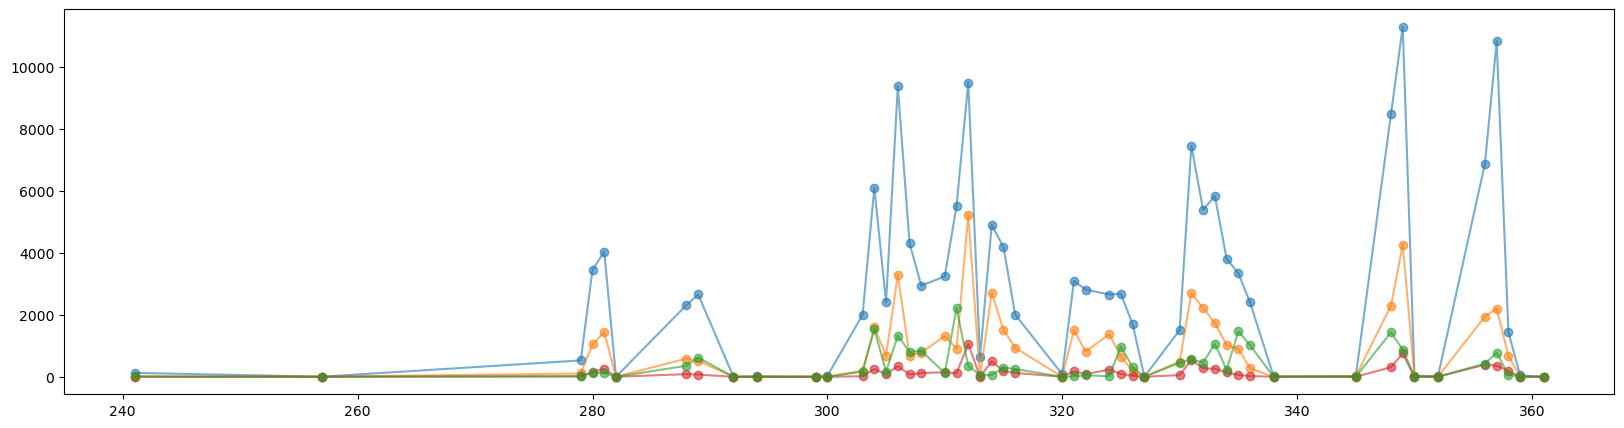

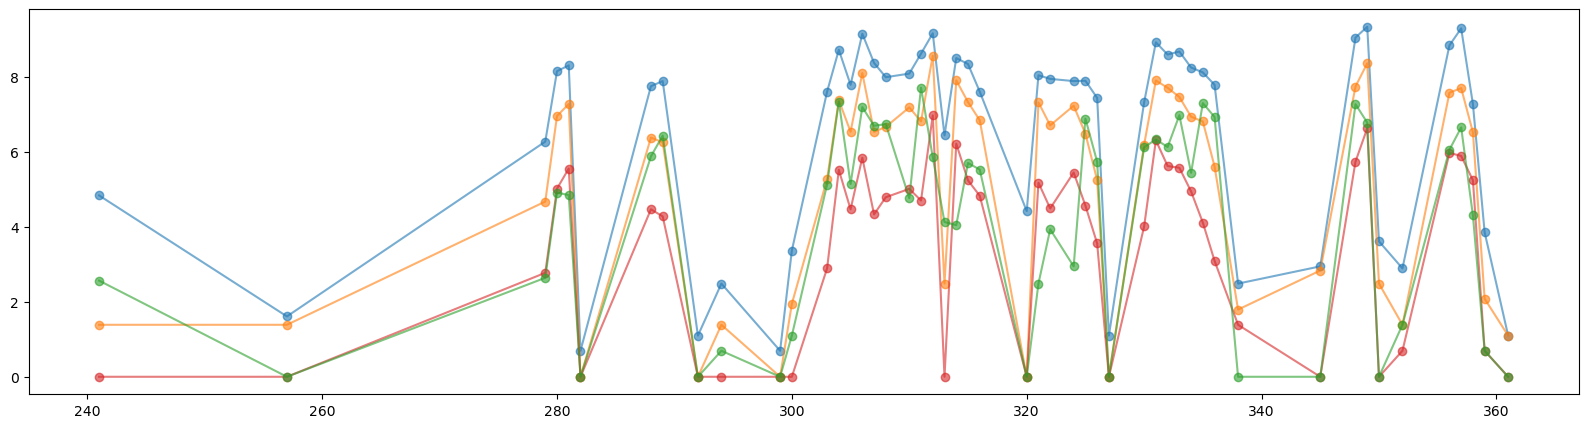

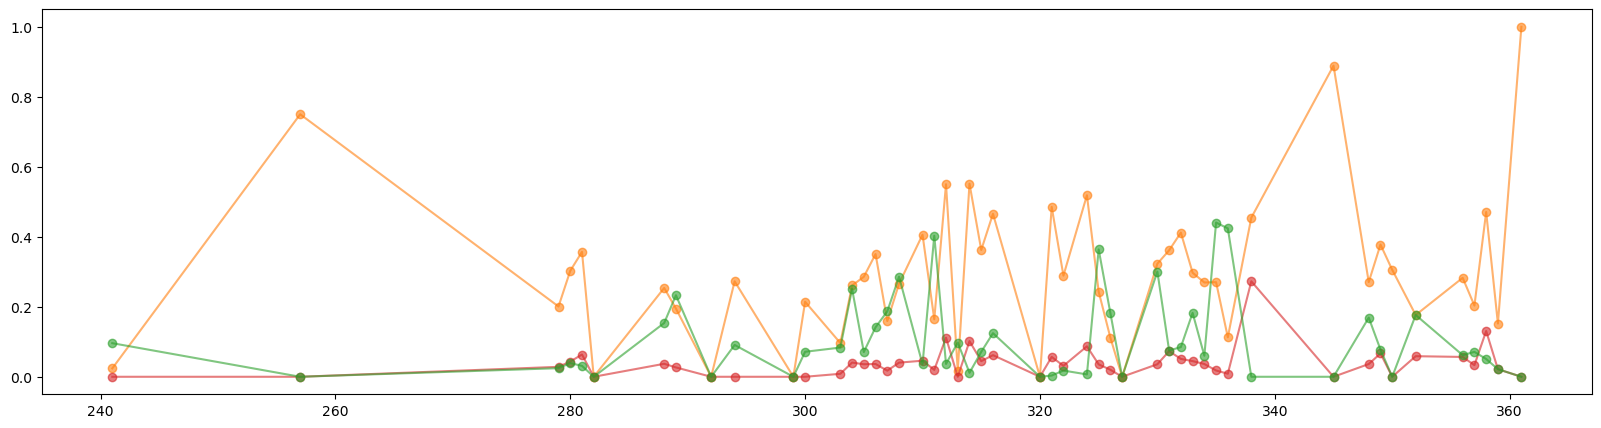

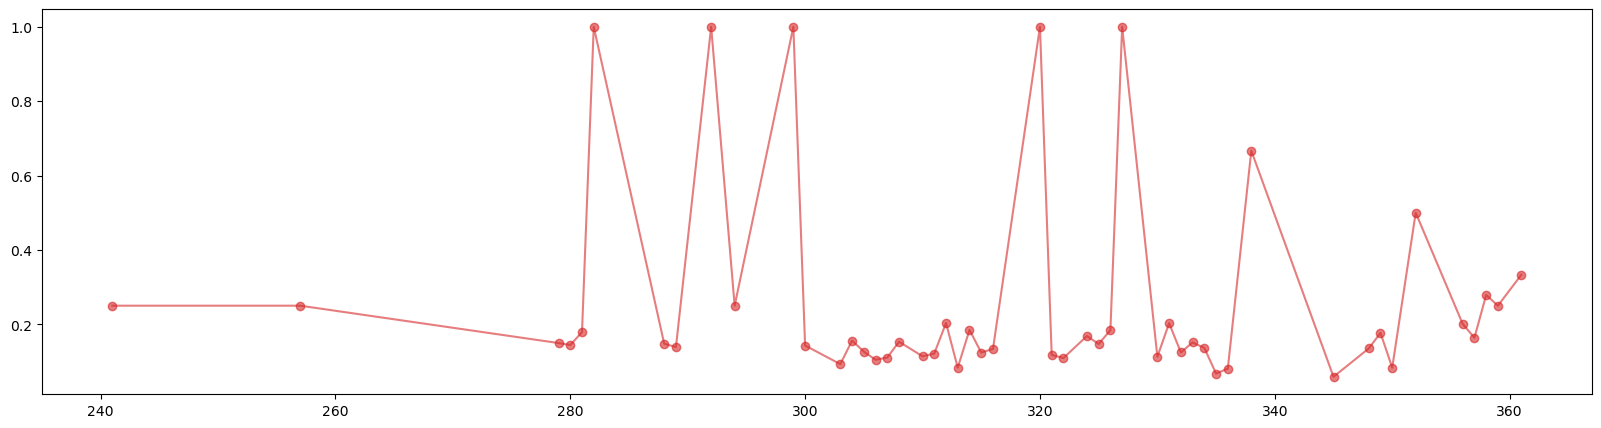

In [27]:
plt.figure(figsize=[20,5])

plt.plot(months_merge['month_id'], months_merge['img_all'], '-o', color = 'C0', alpha = 0.6, label = '')
plt.plot(months_merge['month_id'], months_merge['img_fem'], '-o', color = 'C1', alpha = 0.6)
plt.plot(months_merge['month_id'], months_merge['img_gar'], '-o', color = 'C3', alpha = 0.6)
plt.plot(months_merge['month_id'], months_merge['img_uni'], '-o', color = 'C2', alpha = 0.6)

plt.show()




plt.figure(figsize=[20,5])

plt.plot(months_merge['month_id'], np.log(months_merge['img_all']+1), '-o', color = 'C0', alpha = 0.6)
plt.plot(months_merge['month_id'], np.log(months_merge['img_fem']+1), '-o', color = 'C1', alpha = 0.6)
plt.plot(months_merge['month_id'], np.log(months_merge['img_gar']+1), '-o', color = 'C3', alpha = 0.6)
plt.plot(months_merge['month_id'], np.log(months_merge['img_uni']+1), '-o', color = 'C2', alpha = 0.6)

plt.show()





plt.figure(figsize=[20,5])

plt.plot(months_merge['month_id'], months_merge['fem_ratio'], '-o', color = 'C1', alpha = 0.6)
plt.plot(months_merge['month_id'], months_merge['gar_ratio'], '-o', color = 'C3', alpha = 0.6)
plt.plot(months_merge['month_id'], months_merge['uni_ratio'], '-o', color = 'C2', alpha = 0.6)

plt.show()



plt.figure(figsize=[20,5])
plt.plot(months_merge['month_id'], months_merge['fem_gar_ratio'], '-o', color = 'C3', alpha = 0.6)

plt.show()

In [ ]:
cshapes_mask = ['Gaza', 'West Bank', 'Jordan', 'Palestine', 'Israel', 'Iraq', 'Syria', 'Lebanon', 'Turkey (Ottoman Empire)']
gwno_to_keep = cshapes.loc[cshapes['cntry_name'].isin(cshapes_mask), 'gwcode'].unique()
gid_geom_df = combined_df.loc[(combined_df['gwno'].isin(gwno_to_keep)), ['gid', 'geometry']].drop_duplicates().copy()

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()